In [1]:
import sys
sys.path.append("../")

import utils
from crbm import CRBM
import analysis_methods as am

from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import math
import subprocess as sp
import matplotlib.image as mpimg

In [4]:
# Directory of Stored CRBMs
mdir = "/mnt/D1/globus/cov_trained_crbms/sw/"
rounds = [f"r{i}_w" for i in [3, 4, 11]]

#### Generate Weights

In [5]:
# generate weights in respective
for rid, round in enumerate(rounds):
    # if rid > 0:
    #     break
    checkp, version_dir = am.get_checkpoint_path(round, rbmdir=mdir)
    tmp = CRBM.load_from_checkpoint(checkp)
    utils.all_weights(tmp, name=version_dir +round)

../utils.py:927: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (158400000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
../utils.py:1119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows, ncols, figsize=figsize)


In [2]:
def assign(x):
    if x < 10:
        return "L" # low
    elif x < 1000:
        return "M" # medium
    else:
        return "H" # High

rounds_plain = [f"r{i}" for i in range(3, 13)]
# Stores all data in a dictionary ("data")
all_data = am.fetch_data(rounds_plain, dir="../../datasets/cov/sw/", assignment_function=assign, threads=12)

Process Time 0.4681892395019531
Process Time 0.34801268577575684
Process Time 1.7116875648498535
Process Time 1.0461740493774414
Process Time 1.7525711059570312
Process Time 0.6235122680664062
Process Time 0.15773749351501465
Process Time 0.4307425022125244
Process Time 0.19268345832824707
Process Time 0.4466397762298584


In [7]:
# Generate Sequence Logo for Each round
paths_u, paths_w = [], []
for r in rounds[2:]:
    paths_u.append(am.seq_logo(all_data[all_data["round"] == r], f"{r}_seqlogo0", weight=False, outdir="./generated/"))
    paths_w.append(am.seq_logo(all_data[all_data["round"] == r], f"{r}_w_seqlogo0", weight=True, outdir="./generated/"))

<Figure size 2200x4500 with 0 Axes>

<Figure size 2200x4500 with 0 Axes>

<Figure size 2200x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

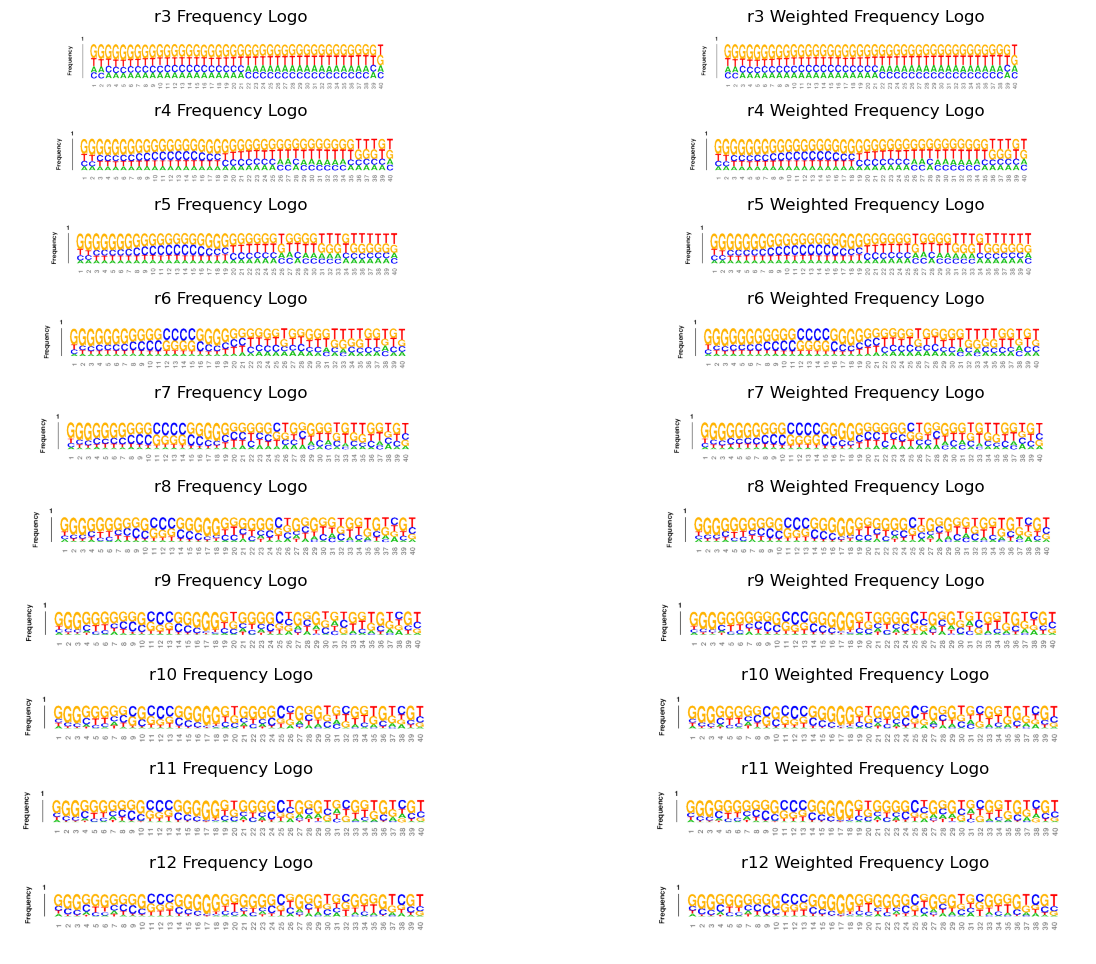

In [8]:
# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(rounds[2:]), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(rounds[2:]):
    img1 = mpimg.imread(f"{paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()

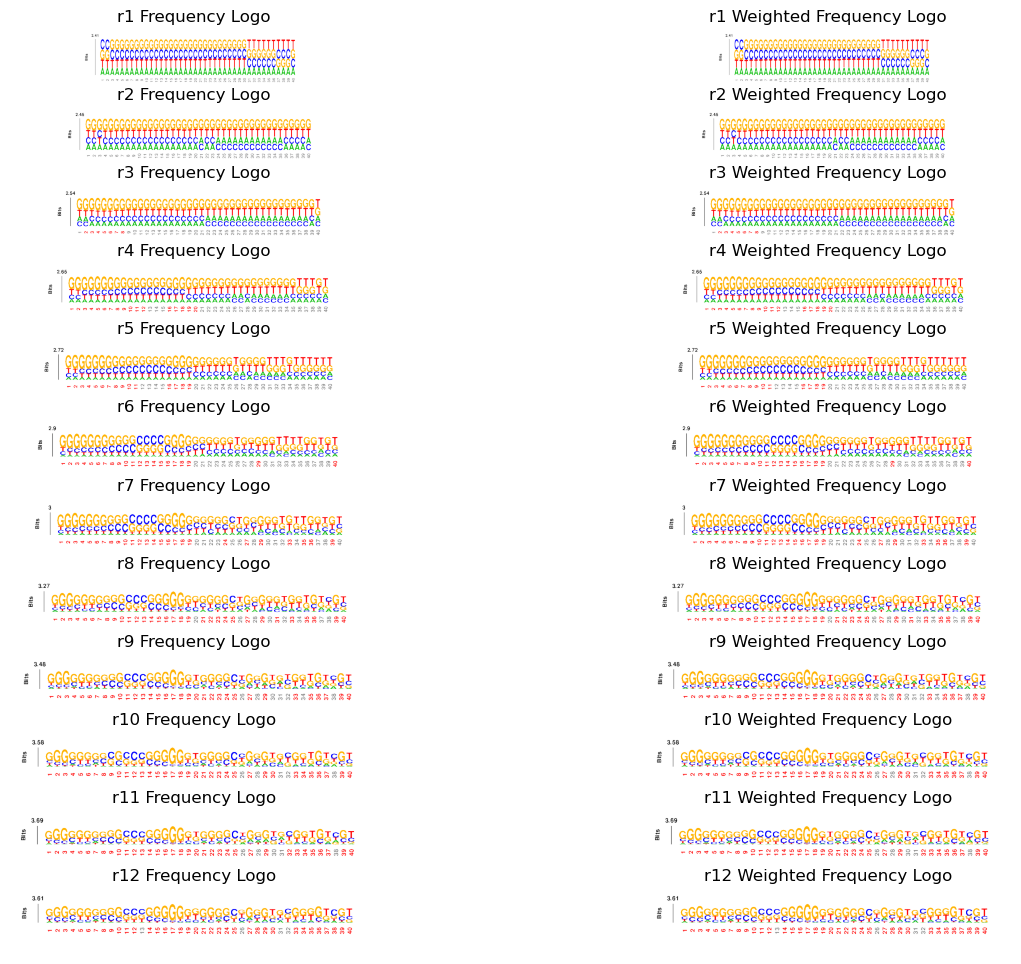

In [8]:
# Seq Logo showing Information of Each Amino Acid at each position
fig, axs = plt.subplots(len(rounds), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(rounds):
    img1 = mpimg.imread(f"{paths_u[rid]}.info.png")
    img2 = mpimg.imread(f"{paths_u[rid]}.info.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()

In [ ]:
def count_dist(data_w_counts, title):
    fig, axs = plt.subplots(2, 1)
    sns.histplot(data=data_w_counts, ax=axs[0], x="round", hue="assignment", multiple="fill", palette="rocket", stat="percent")
    sns.histplot(data=data_w_counts, ax=axs[1], x="round", hue="assignment", multiple="stack", palette="rocket", stat="count")
    # sns.barplot(data=data_w_counts, ax=axs[0], x="round", y="copynum")
    plt.suptitle(title)
    plt.show()

count_dist(all_data, "Unique Sequence Count Distribution")

In [5]:
# Low count == 1, Med count < 10, High count >= 10
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("r3_w", rbmdir=mdir)
r3_crbm = CRBM.load_from_checkpoint(checkp)

In [5]:
# this takes awhile, might be something I optimize further in the future
am.generate_likelihoods(rounds_plain[::2], r3_crbm, all_data, "crbm_r3_sw")

In [6]:
r3_likelihoods = am.get_likelihoods("./generated/crbm_r3_sw.json")

In [15]:
r3_likelihoods["likelihoods"].keys()

dict_keys(['r11_w'])

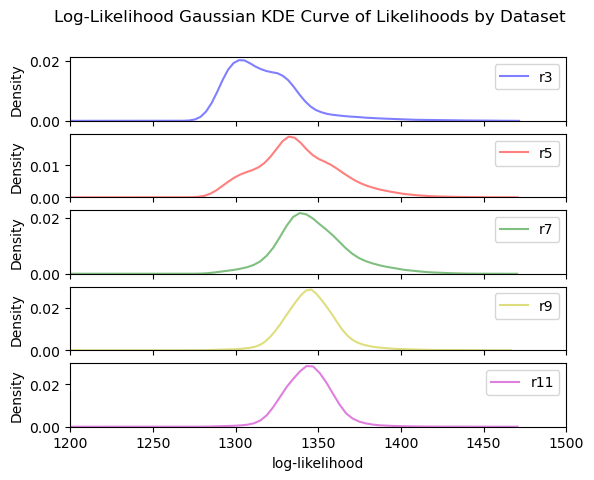

In [8]:
# Plot Likelihoods of Each batch of Data
am.plot_likelihoods(r3_likelihoods["likelihoods"], rounds_plain[::2], rounds_plain[::2], xlim=(1200, 1500), cdf=False)

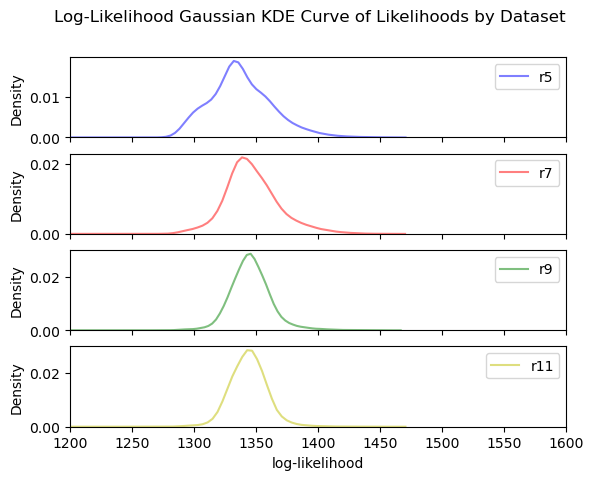

In [20]:
am.plot_likelihoods(r3_likelihoods["likelihoods"], rounds_plain[2::2], rounds_plain[2::2], xlim=(1200, 1600), cdf=False)

In [9]:
print(r3_crbm.log_Z_AIS, r3_crbm.log_Z_AIS_std)

tensor(5099.8410) tensor(0.6652)


In [17]:
def shaded_kde_curve(ax, path, xmin, xmax, color):
    vertices = [ (x, y) for x, y in path.vertices if xmin < x < xmax]
    vertices.insert(0, (xmin, 0.))
    vertices.append((xmax, 0.))
    xfill, yfill = zip(*vertices)
    ax.fill(xfill, yfill, color)

def color_subplot(ax, color):
    for spine in ax.spines.values():
        spine.set_edgecolor(color)

def seqlogo_subplot(ax, path, type="info"):
    img = mpimg.imread(f"{path}.{type}.png")
    ax.imshow(img, interpolation="nearest")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# bounds listed in ascending order
def multi_peak_seq_log_fig(data, likelihoods, round, bounds, weight=False, title=None, xlim=None):
    data_subsets, seqlogo_paths = [], []
    for iid,  i in enumerate(bounds):
        sub = am.data_subset(data, likelihoods, round, i[0], i[1])
        seqlogo_paths.append(am.seq_logo(sub, f"peak{iid+1}_likeli_{round}", weight=weight, outdir="./generated/"))
        data_subsets.append(sub)

    peak_num = len(bounds)
    gs_kw = dict(width_ratios=[1 for x in range(peak_num)], height_ratios=[1, 1])
    fig, axd = plt.subplot_mosaic([['top' for x in range(peak_num)], [f'lower{x}' for x in range(peak_num)]],
                                  gridspec_kw=gs_kw, figsize=(15, 5), constrained_layout=False)

    axd["top"].set_xlim(*xlim)
    sns.kdeplot(likelihoods[round], ax=axd["top"])

    path = axd["top"].get_children()[0].get_path()

    for iid, i in enumerate(bounds):
         shaded_kde_curve(axd["top"], path, i[0], i[1], am.supported_colors[iid])

    axd["top"].set_xlabel("log-likelihood")
    for iid, i in enumerate(bounds):
        color_subplot(axd[f"lower{iid}"], am.supported_colors[iid])
        seqlogo_subplot(axd[f"lower{iid}"], seqlogo_paths[iid])

    if title is None:
        fig.suptitle(title)
    else:
        fig.suptitle(f"Composition of peaks across RBM Likelihood of Round{round}")

    plt.show()



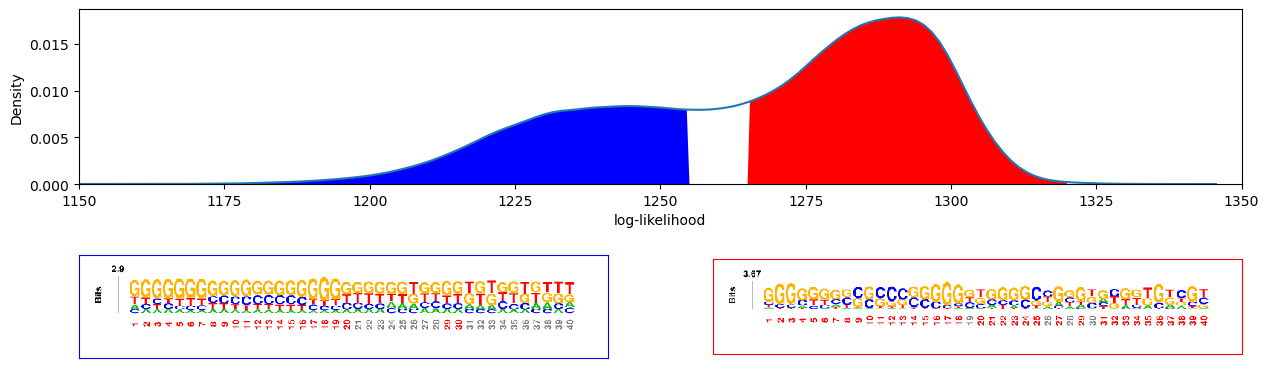

In [19]:
multi_peak_seq_log_fig(all_data, r3_likelihoods["likelihoods"], "r3", [[1180, 1255], [1265, 1320]], weight=False, xlim=(1150, 1350))

In [22]:
exp_seqs = {
    "SP5": 'ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT',
    "SP6": "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT",
    "SP7": "CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT",
    "SP6C": 'CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT',
    "SP634":  "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGG------",
    "SP634G": "CCCATGGTAGGTATTGGTTGGTAGGGATAGTGGG------",
    "SP634C": "CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGG------",
    "SP634A": "CCCATGGTAGGTATTGCATGGTAGGGATAGTGGG------",
    "SP630":  "---CATGGTAGGTATTGCATGGTAGGGATAGTG-------",
    "SP619":  "------------TATTGCATGGTAGGGATAG---------",
}

keys = exp_seqs.keys()
values = exp_seqs.values()
new_exp_seqs = {}
set_nuc = "A"
for i in keys:
    seq = exp_seqs[i]
    while "-" in seq:
        new_char = np.random.choice(["A", "C", "G", "T"])
        # new_char = set_nuc
        ind = seq.find("-")
        seq = seq[:ind] + new_char + seq[ind+1:]
    new_exp_seqs[i] = seq

rand_exp_seqs = new_exp_seqs
rand_exp_set = {'id':list(new_exp_seqs.keys()), 'sequence':list(new_exp_seqs.values())}
rand_exp_pd = pd.DataFrame(rand_exp_set)

exp_A_seqs = {
    "SP5":       'ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT',
    "SP6":       "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT",
    "SP7":       "CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT",
    "SP6C":      'CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT',
    "SP634":     "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGAAAAAA",
    "SP634G":    "ACCATGGTAGGTATTGGTTGGTAGGGATAGTGGGAAAAAA",
    "SP634C":    "CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGAAAAAA",
    "SP634A":    "CCCATGGTAGGTATTGCATGGTAGGGATAGTGGGAAAAAA",
    "SP630":     "AACATGGTAGGTATTGCATGGTAGGGATAGTGAAAAAAAA",
    "SP619":     "AAAAAAAAAAATATTGCATGGTAGGGATAGAAAAAAAAAA",
    "r12_align": "AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTTGATT"
}
exp_A_set = {'id':list(exp_A_seqs.keys()), 'sequence':list(exp_A_seqs.values())}
exp_A_pd = pd.DataFrame(exp_A_set)


exp_set = {'id':list(exp_seqs.keys()), 'sequence':list(exp_seqs.values())}
exp_pd = pd.DataFrame(exp_set)

In [28]:
# exp_2_seqs, exp_2_likelis = r2_rbm.predict(exp_pd)
exp_3_A_seqs, exp_3_A_likelis = r3_crbm.predict(exp_A_pd)
exp_3_seqs, exp_3_likelis = r3_crbm.predict(exp_pd)
exp_3_rand_seqs, exp_3_rand_likelis = r3_crbm.predict(rand_exp_pd)

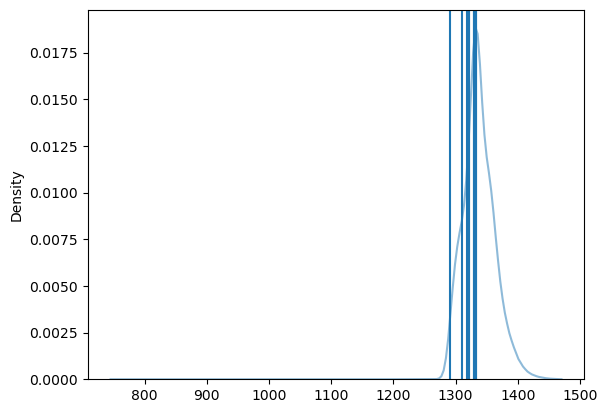

In [29]:
fig, axs = plt.subplots(1, 1)
y = sns.kdeplot(r3_likelihoods["likelihoods"]["r5"], shade=False, alpha=0.5, ax=axs)
for likeli in exp_3_A_likelis:
    plt.axvline(likeli)
plt.show()

In [30]:
labels = list(exp_seqs.keys())
for i in range(len(exp_seqs)):
    print(labels[i], exp_3_A_seqs[i], exp_3_A_likelis[i])

SP5 ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT 1333.28971977756
SP6 CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT 1332.17651600702
SP7 CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT 1330.3214944445563
SP6C CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT 1320.4054285295197
SP634 CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGAAAAAA 1321.6786839323195
SP634G ACCATGGTAGGTATTGGTTGGTAGGGATAGTGGGAAAAAA 1331.6793900774737
SP634C CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGAAAAAA 1310.2727360834315
SP634A CCCATGGTAGGTATTGCATGGTAGGGATAGTGGGAAAAAA 1321.6972098511978
SP630 AACATGGTAGGTATTGCATGGTAGGGATAGTGAAAAAAAA 1318.1574222715562
SP619 AAAAAAAAAAATATTGCATGGTAGGGATAGAAAAAAAAAA 1290.3489024941173


##Clustering with the r3 CRBM

In [11]:
import torch

def clean_ax(ax):
    ax.axis("off")

def dataframe_to_input_crbm(dataframe, base_to_id, v_num, q, weights=False):
    seqs = dataframe["sequence"].tolist()
    oh_ten = torch.zeros((len(seqs), v_num, q), dtype=torch.long)
    for iid, seq in enumerate(seqs):
        for n, base in enumerate(seq):
            oh_ten[iid, n, base_to_id[base]] = 1
    if weights:
        weights = dataframe["copynum"].tolist()
        return oh_ten, weights
    else:
        return oh_ten


In [10]:
import analysis_methods_crbm as am_crbm

In [ ]:
am_crbm.data_with_weights_plot(r3_crbm, all_data[all_data["round"] == "r3"], "hidden1", [0, 1, 2, 3], kdim="full", data="mean")

../utils.py:859: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../utils.py:859: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../utils.py:859: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../utils.py:859: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
/home/jonah/anaconda3/envs/utils

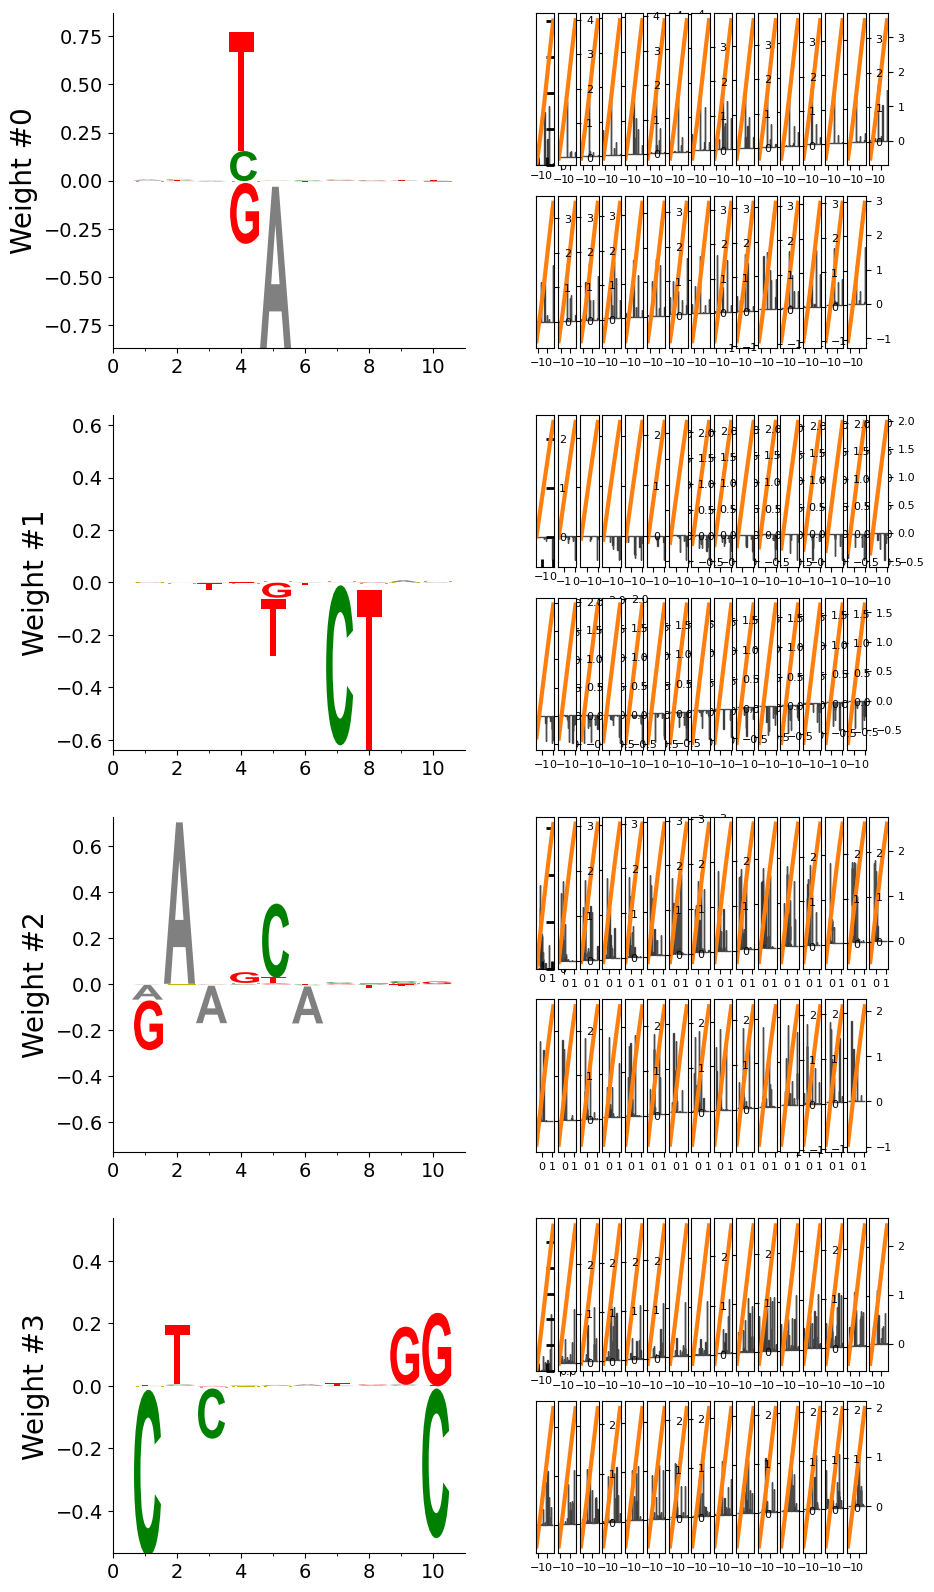

In [27]:
am_crbm.data_with_weights_plot(r3_crbm, all_data[all_data["round"] == "r12"], "hidden2", [0, 1, 2,3], kdim="full", data="mean")

In [28]:
am_crbm.data_with_weights_plot(r3_crbm, all_data[all_data["round"] == "r12"], "hidden3", [0, 1, 2, 3], kdim="mean", data="mean")

NameError: name 'data_with_weights_plot' is not defined

In [7]:
r12_data = all_data[all_data["round"] == "r12"]
# print(r12_data)

In [6]:
r12_copynum = r12_data.copynum.tolist()

In [9]:
r12_by_copynum = r12_data.sort_values("copynum", ascending=False)

Clustering by Inputs on hidden nodes

In [7]:
import torch

def dataframe_to_input_crbm(dataframe, base_to_id, v_num, q, weights=False):
    seqs = dataframe["sequence"].tolist()
    oh_ten = torch.zeros((len(seqs), v_num, q), dtype=torch.long)
    for iid, seq in enumerate(seqs):
        for n, base in enumerate(seq):
            oh_ten[iid, n, base_to_id[base]] = 1
    if weights:
        weights = dataframe["copynum"].tolist()
        return oh_ten, weights
    else:
        return oh_ten

# Produces flat vector of Inputs of each hidden unit (reduced over the convolution dimension (k) by sum or mean)
def flatten_and_reduce_input(Ih, reduction="sum"):
     # Iuk (Batch, hidden number (u), conv number (k))
    if reduction == "sum":
        return torch.cat([Iuk.sum(2) for Iuk in Ih], 1)
    elif reduction == "mean":
        return torch.cat([Iuk.mean(2) for Iuk in Ih], 1)
    else:
        print(f"Reduction {reduction} not supported", file=sys.stderr)
        exit(-1)

def prepare_input_vector(crbm, dataframe):
    if type(dataframe) == pd.DataFrame:
        base_to_id = am.int_to_letter_dicts[crbm.molecule]
        data_tensor = dataframe_to_input_crbm(dataframe, base_to_id, crbm.v_num, crbm.q, weights=False)
    elif type(dataframe) == torch.Tensor:
        data_tensor = dataframe
    input_hiddens = crbm.compute_output_v(data_tensor) # List of Iuk matrices
    return flatten_and_reduce_input(input_hiddens).detach().numpy()

In [8]:
# Primary Component Analysis
from sklearn.decomposition import PCA
import clustering_methods as  cm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

r3_data = all_data[all_data["round"] == "r3"]

r3_input = prepare_input_vector(r3_crbm, r3_data)
scaler = StandardScaler()
input_r3_processed = scaler.fit_transform(r3_input)
X_r3 = input_r3_processed

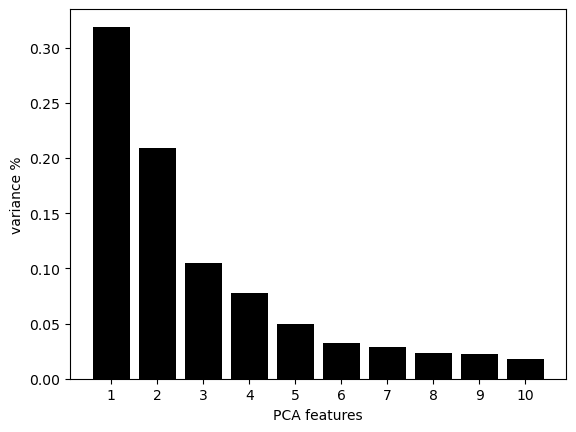

In [9]:
cm.pca_component_check(X_r3, components=10)

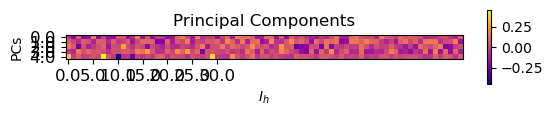

In [10]:
# We will do the first 4 components only, Drop in variance at feature 5

pca_r3 = PCA(n_components=5)
principal_components = pca_r3.fit_transform(X_r3)
PCA_components_pd_r3 = pd.DataFrame(principal_components)
components = pca_r3.components_
cm.view_components(components)


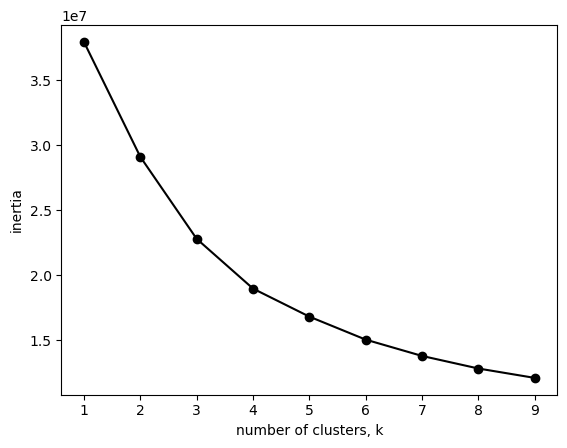

In [11]:
# KMeans on Transformed Sequences
from sklearn.cluster import KMeans

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(PCA_components_pd_r3.iloc[:, :5])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [14]:
# Elbow Point is at 5 so we will run it for 4 clusters
kmeans_pca = KMeans(n_clusters=4, init="k-means++", random_state=38)
kmeans_pca.fit(principal_components)
# Add principal components to dataframe
df_pca_kmeans = pd.concat([r3_data.reset_index(drop=True), pd.DataFrame(principal_components)], axis=1)
df_pca_kmeans.columns.values[-5:] = ["Component 1", "Component 2", "Component 3", "Component 4", "Component 5"]
# Add labels from kmeans
df_pca_kmeans["K-mean PCA Label"] = kmeans_pca.labels_
# Replace integer with label in new column
df_pca_kmeans["Segment"] = df_pca_kmeans["K-mean PCA Label"].map({0:1, 1:2, 2:3, 3:4, 4:5, 5:6})

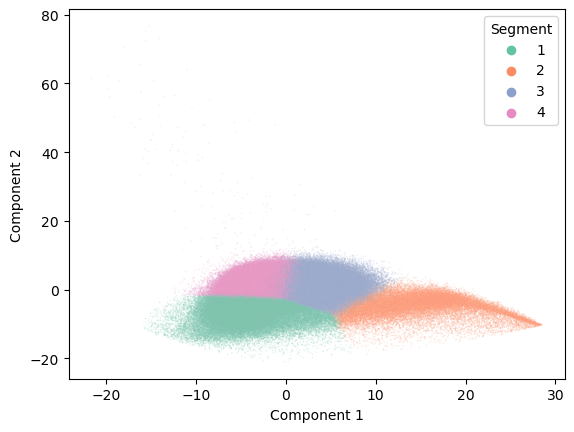

In [15]:
# colors = ['#747FE3', '#8EE35D', '#E37346']
sns.scatterplot(data=df_pca_kmeans, x="Component 1", y="Component 2", hue="Segment", alpha=0.2, s=1, palette="Set2")
plt.show()

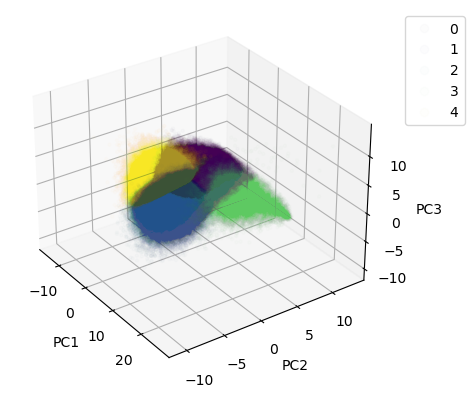

In [24]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".")
ax.view_init(30, -35)  # Set viewing angle
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

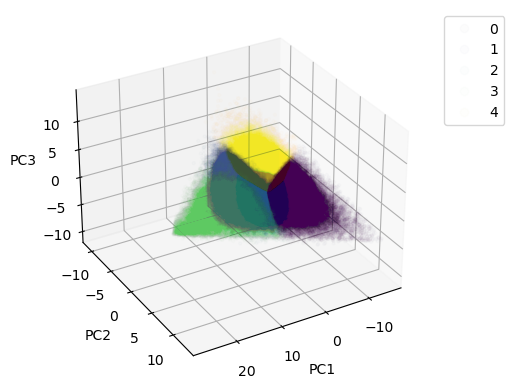

In [25]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".")
ax.view_init(30, 60)  # Set viewing angle
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

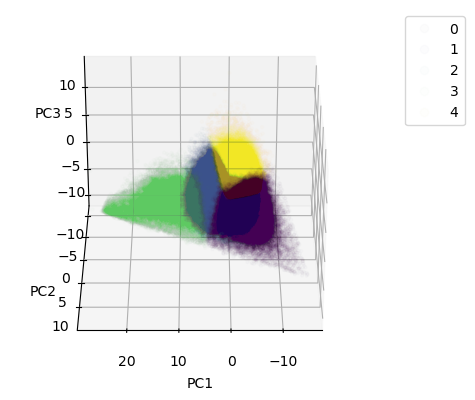

In [26]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".")
ax.view_init(30, 90)  # Set viewing angle
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

Now we need to see what the primary components are learning

Let's try the same exact thing on round 2 now

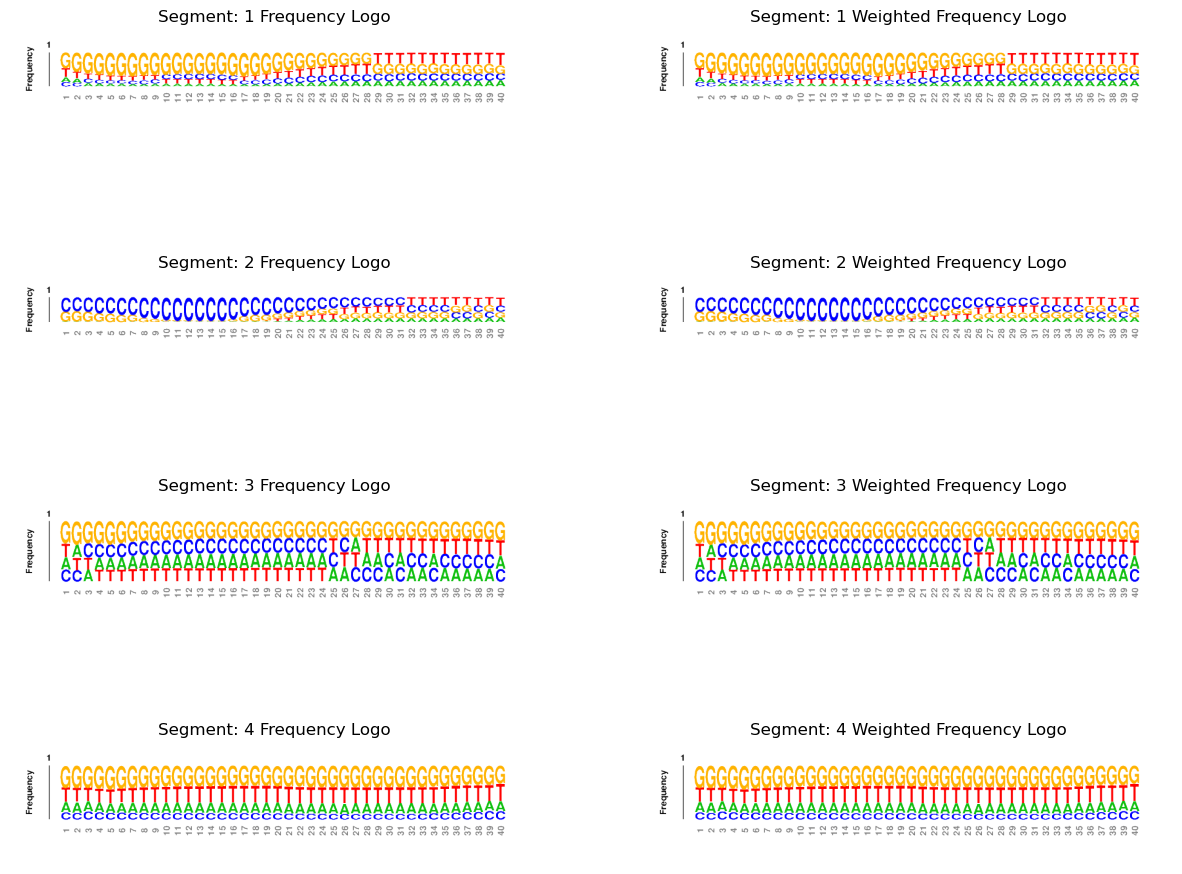

In [16]:
segments = [1, 2, 3, 4]

# Generate Sequence Logo for Each Cluster
pca_paths_u, pca_paths_w = [], []
for seg in segments:
    pca_paths_u.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"r3_pcak_c{seg}_seqlogo", weight=False, outdir="./generated/"))
    pca_paths_w.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"r3_pcak_c{seg}_seqlogo", weight=True, outdir="./generated/"))


# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(segments), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(segments):
    img1 = mpimg.imread(f"{pca_paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{pca_paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"Segment: {r} Frequency Logo")
    axs[rid][1].set_title(f"Segment: {r} Weighted Frequency Logo")

plt.show()

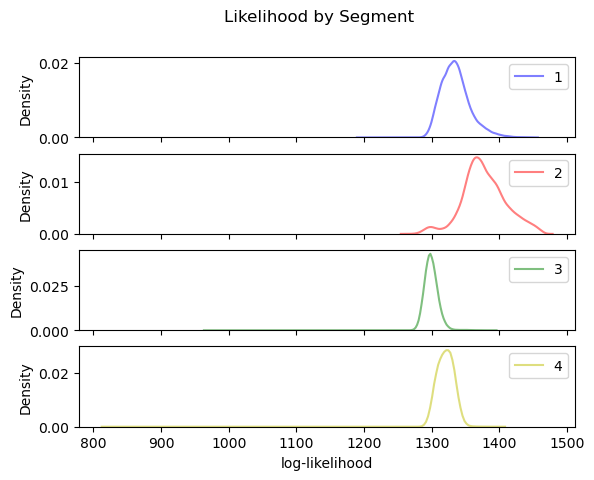

In [17]:
segments = [1, 2, 3, 4]
# Plot Likelihood Curves of individual segments
df_pca_kmeans["likelihood"] = r3_likelihoods["likelihoods"]["r3"]
likelihood_dict = {}
for seg in segments:
    segment_subset = df_pca_kmeans[df_pca_kmeans["Segment"] == seg]
    likelihoods = segment_subset.likelihood.tolist()
    likelihood_dict[seg] = likelihoods


am.plot_likelihoods(likelihood_dict, segments, segments, title="Likelihood by Segment", xlim=None)

In [21]:
seg1 = df_pca_kmeans[df_pca_kmeans["Segment"] == 1].sort_values("copynum", axis=0, ascending=False)
seg1.head(20)

,sequence,copynum,round,assignment,Component 1,Component 2,Component 3,Component 4,Component 5,K-mean PCA Label,Segment,likelihood
308367,TGGGTGGGGGGGCGGGGGGCCCTGCTTACTGAACGTTTCG,0.57516,r3,L,-3.372677,-10.663813,2.122832,2.715199,0.392167,0,1,1354.448377
270514,GGGAGGGTGGGAGGGGGGTATACGTTGTTGCGCTATTTCG,0.57446,r3,L,-5.803821,-6.254540,3.196013,1.762002,-0.178224,0,1,1338.732815
221759,GGGAGGGAGGGTGGGGGGTTCTCGCTGCGGGTTTTGGTGC,0.56197,r3,L,-6.114789,-7.158986,1.074372,-2.307517,-0.115051,0,1,1346.865519
592015,TGGGAGGGTGGGAGGGGGGTCGATCGGTGTTCTTGAGAGT,0.55769,r3,L,-7.072250,-7.581464,1.683500,0.738134,0.083416,0,1,1340.888392
106778,GGGTGGGAGGGCGGGGGGCTGCTCTTCGTTACGGCGCGGG,0.55555,r3,L,-3.195739,-9.366381,0.265415,1.476881,0.429051,0,1,1348.062967
172148,TGTGGGTGGGAGGGAGGGGGGGTCCAAATTGCGAATTTGG,0.54762,r3,L,-6.156040,-7.163558,0.079681,4.726373,0.501222,0,1,1344.487600
562294,TTCGGGCGGGAGGGAGGGGGGTACGTATCTAGTTCTCAGC,0.54381,r3,L,-4.745372,-7.705092,2.733594,3.970888,0.011569,0,1,1328.957777
15125,ATGGGAGGGGGGGTGGGGGGTGCCGCGTCTGTTCCCTATA,0.53709,r3,L,-5.777051,-12.534114,2.320336,1.986381,0.359410,0,1,1341.820352
438869,TGGGTGGGAGGGAGGGGGGCTTTATTCCGGTGTTTTTTCG,0.53698,r3,L,-6.138662,-7.187892,5.769345,-0.161044,-0.459553,0,1,1349.654538
530755,GGGAGGGAGGGCGGGGGGCTAGGTGTACGCTCGGTTTAGT,0.53141,r3,L,-4.913374,-8.461782,0.386320,1.163696,0.162713,0,1,1350.273627


In [19]:
seg2 = df_pca_kmeans[df_pca_kmeans["Segment"] == 2].sort_values("likelihood", axis=0, ascending=False)
seg2.head(20)

,sequence,copynum,round,assignment,Component 1,Component 2,Component 3,Component 4,Component 5,K-mean PCA Label,Segment,likelihood
415924,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCT,0.03947,r3,L,28.399375,-10.347547,-1.906915,0.708448,1.546901,1,2,1466.346527
621995,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCG,0.03862,r3,L,28.457861,-10.231372,-2.277160,0.896377,1.607507,1,2,1466.270503
237892,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC,0.04902,r3,L,28.520622,-10.269997,-2.140621,0.950966,1.580953,1,2,1466.142500
391917,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGG,0.03128,r3,L,28.225885,-10.092013,-2.538535,0.638283,1.636251,1,2,1466.119731
66311,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTT,0.02265,r3,L,28.161729,-10.379103,-1.522463,0.280050,1.463011,1,2,1465.562598
548210,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCA,0.03499,r3,L,28.511173,-10.256770,-2.121871,0.982375,1.589327,1,2,1465.292898
616698,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGT,0.02136,r3,L,28.167398,-10.208189,-2.168290,0.450355,1.575646,1,2,1465.248820
211164,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTC,0.02460,r3,L,28.282976,-10.301553,-1.756169,0.522567,1.497063,1,2,1465.176242
469345,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGC,0.02847,r3,L,28.288645,-10.130639,-2.401996,0.692872,1.609697,1,2,1465.168414
398109,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGGG,0.03056,r3,L,27.860754,-9.890874,-2.845388,0.337652,1.680905,1,2,1464.873573


In [20]:
seg3 = df_pca_kmeans[df_pca_kmeans["Segment"] == 3].sort_values("copynum", axis=0, ascending=False)
seg3.head(20)

,sequence,copynum,round,assignment,Component 1,Component 2,Component 3,Component 4,Component 5,K-mean PCA Label,Segment,likelihood
549619,TGGGGGCGGCGGAGGCCATATTACCTTAGCGTGTGCACTT,0.26934,r3,L,1.534902,-3.119860,1.941316,0.656366,-0.329520,2,3,1314.285758
191521,GGGGGCGGTGGAGGCCTTTTGCACTACTCATTGTAGGTCG,0.20976,r3,L,1.033735,-2.974643,4.014549,0.412907,-0.584456,2,3,1326.092855
375346,GGGGGAGGTGGAGGCCTTTCATTCCCGGCTTTCAATTTTT,0.20942,r3,L,1.798554,-4.058437,5.823878,-0.419823,-0.767927,2,3,1314.000997
117927,TTACGGCTCTGTTGTCATCTATGGCCAGGGCTAGGCCGGA,0.17024,r3,L,2.438884,3.261133,-3.413420,-2.311472,0.471018,2,3,1305.069091
506249,GACACTGGGCAGGCCGGCGCTCTCTGCTGAGGGAACTTCA,0.17024,r3,L,2.685923,-3.939728,-0.855859,-0.411734,0.445786,2,3,1300.568060
34352,TGGTTGGTCCCCTCCAGGTGACACACAAGAGTTAGCCGGG,0.17024,r3,L,5.765022,1.440206,-2.936821,1.821361,0.461980,2,3,1307.975303
171766,ATATGGCGGAAAGTCGGCCCCGAACCACCGGTTGCTTCAG,0.17024,r3,L,5.571629,-2.598940,-0.037668,2.938983,-0.070665,2,3,1295.802906
193772,GAGATGACGGCGGGACGTGAATATTATCTGATACGAGTGG,0.17024,r3,L,-1.002311,0.969823,2.207286,4.220391,-0.545431,2,3,1292.752773
425096,GTGTGGCGGGTTCACTGAGGTGATGAACAATGGCTCCCCG,0.17024,r3,L,0.049915,-0.329501,-1.059750,2.388555,0.060680,2,3,1300.122248
169665,TGCAGGGTCGTCAGCCAGGTACGCTCTTGGGGTGTAAGTA,0.17024,r3,L,1.897028,-1.194902,-0.440179,-1.806961,0.297547,2,3,1318.794017


In [40]:
seg4 = df_pca_kmeans[df_pca_kmeans["Segment"] == 4].sort_values("likelihood", axis=0, ascending=False)
seg4.head(20)

,sequence,copynum,round,assignment,Component 1,Component 2,Component 3,Component 4,K-mean PCA Label,Segment,likelihood
3583,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTT,2.0,r3,L,23.666910,4.871938,3.253212,0.369326,3,4,801.702837
236798,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTT,1.0,r3,L,23.200789,4.634190,3.731475,0.412781,3,4,801.633912
437671,CCCCCCCCCCCCCCCCCCCCCCCCCCGGGGTTTTTTTTGG,1.0,r3,L,15.557629,3.746609,4.324515,2.175669,3,4,801.439423
614238,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTT,3.0,r3,L,24.021978,5.143604,2.814575,0.379497,3,4,801.282729
30170,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTTAGGG,1.0,r3,L,20.018502,3.429895,4.186295,1.085711,3,4,801.100414
387812,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCGCTTTTTT,1.0,r3,L,22.186960,4.889215,3.538553,0.888030,3,4,800.840409
165393,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCGGGGTTTTTTA,1.0,r3,L,18.051992,5.076899,3.289961,1.661246,3,4,800.754356
259396,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTT,6.0,r3,L,24.311108,5.394693,2.355384,0.401145,3,4,800.746971
148808,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTC,1.0,r3,L,23.824834,4.896947,3.030846,0.383932,3,4,800.645715
211411,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTCT,1.0,r3,L,23.528426,4.739363,3.493977,0.287105,3,4,800.597452


In [41]:
seg5 = df_pca_kmeans[df_pca_kmeans["Segment"] == 5].sort_values("likelihood", axis=0, ascending=False)
seg5.head(20)

,sequence,copynum,round,assignment,Component 1,Component 2,Component 3,Component 4,K-mean PCA Label,Segment,likelihood
131245,TGGGAGGGGGGGGGGGGGGTGTTTTTTTTTTTTTTTTTGG,1.0,r3,L,-7.097698,1.175079,8.003713,-3.853376,4,5,772.391751
597920,GGGTGGGGGGGGGGGGGTTTTTTTTTTGCGGTTTTTTTTT,1.0,r3,L,-6.507270,1.125895,8.513134,-3.129304,4,5,768.755710
229561,GGGTGGGGGGGGGGGGGTTTTTTTTTGGTCGTTTTTTTTT,1.0,r3,L,-6.552813,1.185017,8.475044,-2.894173,4,5,768.530477
118515,GGGCGGGGGGGGGGGGGGTTTTTTTTTTGGTACTTTTTGT,1.0,r3,L,-6.217436,1.734800,6.869026,-3.273725,4,5,766.668283
183420,TGGGAGGGGGGGGGGGGGCGTTTTTTTTTAGTTTTTTTTT,1.0,r3,L,-6.008159,1.582710,7.054184,-4.112517,4,5,766.637318
291251,TGGGGGGGGGGGGTTTGGGTTTGTTTTTTTTATTGTGGGG,1.0,r3,L,-7.047703,0.601970,7.701911,-1.861032,4,5,764.721021
282084,GGGGGGGGGGTGGGTTTTTTTTGGTTGGGGTCAGTTTTTT,1.0,r3,L,-7.043795,1.003937,6.705872,-0.427312,4,5,762.853519
453719,GGTTGTTTTTAGGTGGGGTTGGGGGGGGGGTTTTTTTTAG,1.0,r3,L,-7.569924,0.248109,5.469358,1.477872,4,5,761.498352
158604,GGGGGGGGGGGGGGGAAGGGTTTGTTTTTTTTTTTTTAAT,1.0,r3,L,-6.718251,1.137398,6.183383,-4.287914,4,5,761.340116
466296,GTCAGTTTGGGGGGGGGGGGTTTTTTTTGGGGGTCTTTTT,1.0,r3,L,-7.099475,1.295324,5.994130,-0.722763,4,5,761.324680


In [ ]:
utils.cat_to_seq

In [11]:
seqs, hiddens = utils.gen_data_lowT(r3_crbm, beta=2, which = 'marginal' ,Nchains=100, Lchains=500, Nthermalize=200, Nstep=2, N_PT=5, reshape=True, update_betas=False)
seqs_zero, hiddens_zero = utils.gen_data_zeroT(r3_crbm, which = 'marginal' ,Nchains=50, Lchains=500, Nthermalize=100, Nstep=2, N_PT=1, reshape=True, update_betas=False)

In [12]:
def prep_gen_seqs_pd(crbm, seqs):
    gen_data = seqs.detach()
    input_gen = prepare_input_vector(crbm, gen_data)
    X_gen = scaler.transform(input_gen)
    pca_generated = pca_r3.transform(X_gen)
    clusters_gen = kmeans_pca.predict(pca_generated)
    gen_seqs = utils.cat_to_seq(gen_data.argmax(-1).detach().numpy(), molecule=crbm.molecule)
    gen_seqs_input_pd = pd.DataFrame({"sequence": gen_seqs, "round":clusters_gen})
    _, gen_likelihoods = crbm.predict(gen_seqs_input_pd)
    gen_seqs_input_pd["likelihood"] = gen_likelihoods
    return gen_seqs_input_pd

In [13]:
zeroT_pd = prep_gen_seqs_pd(r3_crbm, seqs_zero)
lowT_pd = prep_gen_seqs_pd(r3_crbm, seqs)

In [ ]:
gen_data = seqs.detach()
input_gen = prepare_input_vector(r3_crbm, gen_data)
X_gen = scaler.transform(input_gen)
pca_generated = pca_r3.transform(X_gen)
clusters_gen = kmeans_pca.predict(pca_generated)
gen_seqs = utils.cat_to_seq(gen_data.argmax(-1).detach().numpy(), molecule=r3_crbm.molecule)
gen_seqs_input_pd = pd.DataFrame({"sequence": gen_seqs, "round":clusters_gen})
_, gen_likelihoods = r3_crbm.predict(gen_seqs_input_pd)
gen_seqs_input_pd["likelihood"] = gen_likelihoods

In [14]:
# Plot Likelihoods as kde curves with each round in a new row
def plot_likelihoods_pd(likelihood_pd, columnkey, keys, labels, title=None, xaxislabel="log-likelihood", xlim=None, cdf=False):
    colors = am.supported_colors
    plot_num = len(keys)
    fig, axs = plt.subplots(plot_num, 1, sharex=True, sharey=False)
    for xid, x in enumerate(keys):
        if xlim is not None:
            axs[xid].set_xlim(*xlim)
        y = sns.kdeplot(likelihood_pd[likelihood_pd[columnkey] == x].likelihood.tolist(), shade=False, alpha=0.5, color=colors[xid], ax=axs[xid], label=labels[xid], cumulative=cdf)
        if xid == len(keys) - 1:
            y.set(xlabel=xaxislabel)
        axs[xid].legend()
    if title:
        fig.suptitle(title)
    else:
        fig.suptitle("Log-Likelihood Gaussian KDE Curve of Likelihoods by Dataset")
    plt.show()

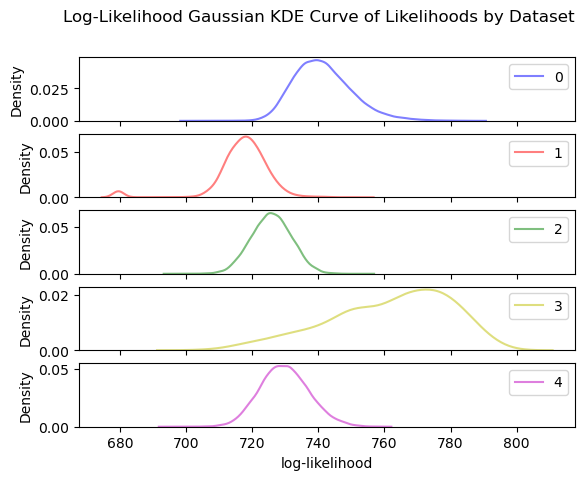

In [15]:
plot_likelihoods_pd(lowT_pd, "round", [0, 1, 2, 3, 4], [0, 1, 2, 3, 4])

No handles with labels found to put in legend.
No handles with labels found to put in legend.


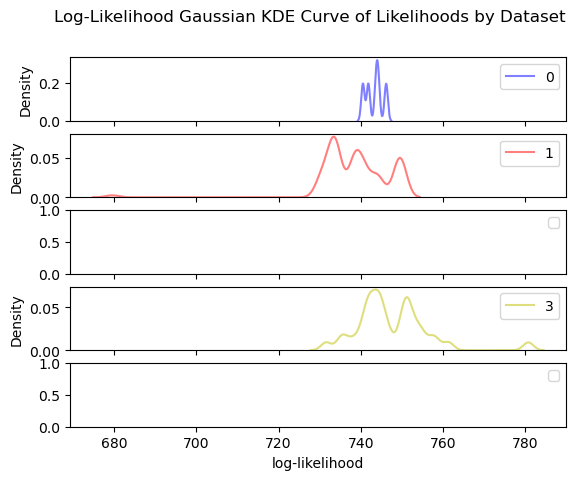

In [16]:
plot_likelihoods_pd(zeroT_pd, "round", [0, 1, 2, 3, 4], [0, 1, 2, 3, 4])

In [26]:
lowT_pd[lowT_pd["round"] == 4].sort_values("likelihood", ascending=False).head(200)

,sequence,round,likelihood
36575,GGTAGTGGTTTGGTTGGGGGGGTTTGTTAGGTGTTTGTGG,4,758.865555
20491,GGGTTGTGGGTTAGGGGGGGTTTAGGTAGTTTAGGTATGG,4,758.480590
32492,AGGGGTTGGGGGGGGTTTGTTTAGGTTTATGGGTTGGTCA,4,757.815208
14075,GTGGGTTTTAGGGGGGGGGGAGTGTTTGGTTTTTTGTTTA,4,757.770517
16533,AGGGGGTGGGGTTGTAGGGGTTTATGGTTTGGTTTGGTTG,4,757.315495
...,...,...,...
39287,GGGTGTAGGCTGTGGGTGTAGTTGGTTAGGTTTAGGTCCT,4,747.538344
5842,GGCGCAGGGGGTGGGGGGTTTTATGTTTCGTTGGTTAATG,4,747.532260
4903,GGTGGGAGTGGGGGTTGTTGGGTGTGTATTTCGTTGTTCG,4,747.502695
36600,GGGGGGGGGTTGACTTATGTTTTGGGTTGGGGACTTGGTG,4,747.493904


In [19]:
zeroT_pd[zeroT_pd["round"] == 1].sort_values("likelihood", ascending=False).head(200)

,sequence,round,likelihood
2500,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406
2829,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406
2842,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406
2841,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406
2840,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406
...,...,...,...
2900,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406
2899,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406
2898,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406
2897,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406


In [24]:
from functools import reduce

r11_data = all_data[all_data["round"] == "r11"]

def get_common_vals(pd1, pd2, key):
    """Takes two pandas dataframes, and return list of shared values in each dataframe column specified by optional parameter key"""
    return list(reduce(set.intersection, map(set, [pd1[key], pd2[key]])))

common_seqs_r3_r11 = get_common_vals(r11_data, r3_data, "sequence")
common_seqs_lowT_r11 = get_common_vals(r11_data, lowT_pd, "sequence")
common_seqs_zeroT_r11 = get_common_vals(r11_data, zeroT_pd, "sequence")
common_seqs_zeroT_r3 = get_common_vals(r3_data, zeroT_pd, "sequence")
common_seqs_lowT_r3 = get_common_vals(r3_data, lowT_pd, "sequence")


print(len(common_seqs_zeroT_r11), len(common_seqs_lowT_r11), len(common_seqs_zeroT_r3), len(common_seqs_lowT_r3))

0 0 0 0


In [89]:
3

250000

In [82]:
r11_data.shape[0]

301571

In [90]:
print(len(common_seqs_lowT))
print(len(common_seqs_zeroT))

0
0


In [ ]:
segments = [1, 2, 3, 4, 5]
# Plot Likelihood Curves of individual segments
df_pca_kmeans["likelihood_r11"] = r3_likelihoods["likelihoods"]["r11"]
likelihood_dict = {}
for seg in segments:
    segment_subset = df_pca_kmeans[df_pca_kmeans["Segment"] == seg]
    likelihoods = segment_subset.likelihood.tolist()
    likelihood_dict[seg] = likelihoods


am.plot_likelihoods(likelihood_dict, segments, segments, title="Likelihood by Segment", xlim=(670, 820))

In [67]:
seqs, hiddens = utils.gen_data_lowT(r12_crbm, beta=1, which = 'marginal' ,Nchains=20, Lchains=500, Nthermalize=0, Nstep=1, N_PT=1, reshape=True, update_betas=False)

In [68]:
gen_data_pd = seqs.detach()
input_gen = prepare_input_vector(r12_crbm, gen_data_pd)
X_gen = scaler.transform(input_gen)
pca_generated = pca.transform(X_gen)
clusters_gen = kmeans_pca.predict(pca_generated)

In [69]:
def cat_to_seq(categorical_tensor):
    cat_ten = categorical_tensor.numpy()
    int_to_base = {0: 'A', 1: 'C', 2: 'G', 3: 'T', 4: '-'}
    seqs = []
    for i in range(categorical_tensor.shape[0]):
        seq = ""
        for j in range(categorical_tensor.shape[1]):
            seq += int_to_base[cat_ten[i][j]]
        seqs.append(seq)
    return seqs

gen_seqs = cat_to_seq(gen_data_pd.argmax(-1))

In [70]:
gen_seqs_input_pd = pd.DataFrame({"sequence": gen_seqs, "round":clusters_gen})
gen_likelihoods = r12_crbm.predict(gen_seqs_input_pd)

In [71]:
gen_full_pd = gen_seqs_input_pd
gen_full_pd["likelihood"] = gen_likelihoods[1]

gen_likelihood_dict = {}
clusters = np.arange(1, 8)
for cluster in clusters:
    cluster_subset = gen_full_pd[gen_full_pd["round"] == cluster]
    likelihoods = cluster_subset.likelihood.tolist()
    gen_likelihood_dict[cluster] = likelihoods

No handles with labels found to put in legend.
No handles with labels found to put in legend.


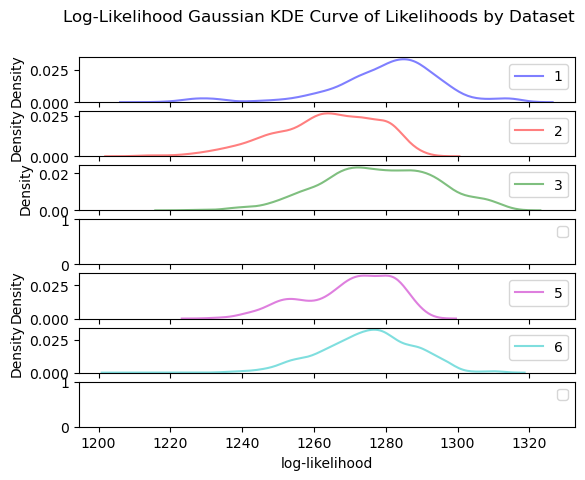

In [72]:
am.plot_likelihoods(gen_likelihood_dict, clusters, clusters)

In [87]:
# Let's classify each of the experimental sequences in a cluster
exp_seqs = {
    "SP5_sup": 'ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT',
    "SP5_pap": '-ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTTG',
    "SP6": "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT",
    "SP7_sup": "CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT",
    "SP7_pap": "-AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGAT",
    "SP6C": 'CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT',
    "SP634":  "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGG------",
    "SP634G": "CCCATGGTAGGTATTGGTTGGTAGGGATAGTGGG------",
    "SP634C": "CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGG------",
    "SP634A": "CCCATGGTAGGTATTGCATGGTAGGGATAGTGGG------",
    "SP630":  "---CATGGTAGGTATTGCATGGTAGGGATAGTG-------",
    "SP619":  "------------TATTGCATGGTAGGGATAG---------",
}

keys = exp_seqs.keys()
values = exp_seqs.values()
new_exp_seqs = {}
set_nuc = "A"
for i in keys:
    seq = exp_seqs[i]
    while "-" in seq:
        # new_char = np.random.choice(["A", "C", "G", "T"])
        new_char = set_nuc
        ind = seq.find("-")
        seq = seq[:ind] + new_char + seq[ind+1:]
    new_exp_seqs[i] = seq

rand_exp_seqs = new_exp_seqs
rand_exp_set = {'id':list(new_exp_seqs.keys()), 'sequence':list(new_exp_seqs.values())}
rand_exp_pd = pd.DataFrame(rand_exp_set)

In [88]:
input_exp = prepare_input_vector(r12_crbm, rand_exp_pd)
X_exp = scaler.transform(input_exp)
pca_exp = pca.transform(X_exp)
clusters_exp = kmeans_pca.predict(pca_exp)
_, exp_r12_likelihoods = r12_crbm.predict(rand_exp_pd)
print(clusters_exp)

[5 5 5 5 5 5 5 5 5 0]


SP5 1278.2952021701003
SP6 1277.5987851952877
SP7 1273.983184315899
SP6C 1272.2539308398236
SP634 1250.1074460143745
SP634G 1248.1686831422721
SP634C 1242.1351936718138
SP634A 1238.205802402089
SP630 1241.8425745136055
SP619 1240.9896687986911


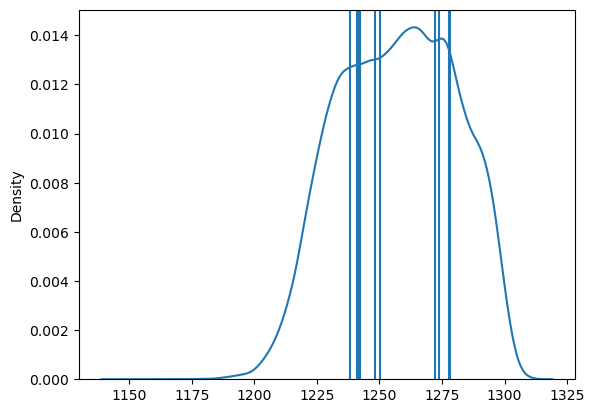

In [89]:
fig, axs = plt.subplots(1, 1)
sns.kdeplot(x=likelihood_dict["6"])


for iid, i in enumerate(new_exp_seqs.keys()):
    print(i, exp_r12_likelihoods[iid])
    plt.axvline(exp_r12_likelihoods[iid])

plt.show()

In [91]:
r12_pd = all_data[all_data["round"] == "r12"] # r12_data
r12_pd["cluster"] = df_pca_kmeans["Segment"].tolist()
r12_pd["likelihood"] = r12_likelihoods["likelihoods"]["r12"]

r12_c6_pd = r12_pd[r12_pd["cluster"] == "6"]

r12_highest = r12_c6_pd[r12_c6_pd["likelihood"] > 1285]
r12_mid = r12_c6_pd[r12_c6_pd["likelihood"] > 1250]

<ipython-input-91-1cdc2f7d2c30>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r12_pd["cluster"] = df_pca_kmeans["Segment"].tolist()
<ipython-input-91-1cdc2f7d2c30>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r12_pd["likelihood"] = r12_likelihoods["likelihoods"]["r12"]


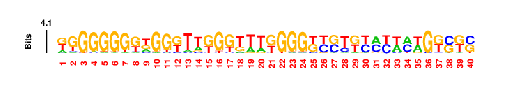

In [93]:
sl = am.seq_logo(r12_highest, "r12_c6_high_likeli", weight=False, outdir="./generated/")
fig, axs = plt.subplots(1, 1)
am.seqlogo_subplot(axs, sl, type="info")
plt.show()

In [98]:
r12_c6_pd.head()

,sequence,copynum,round,assignment,cluster,likelihood
5,ATAATGTTAACAATGGGGGGTGGGAAGGGTAGGGGGTCGT,1.0,r12,L,6,1256.347018
16,CTATGGTAGGTATTGCTTGGTAGGGATAGTGGGTTTGCTG,1.0,r12,L,6,1259.633689
26,CTGGGGGGTGGGTCTGGGTATGGGGTCTGCACTATAGCTC,1.0,r12,L,6,1271.011836
37,CCCATGTATGTTATTGATTGTTTGGATTTGTGGGCTTGAT,1.0,r12,L,6,1243.485433
62,AAGGAGGGTAGGTAGTGCTCGGTAGGGAAACTCTGCCGAT,1.0,r12,L,6,1262.474035


In [100]:
r12_c6_pd_by_copynum = r12_c6_pd.sort_values("copynum", axis=0, ascending=False)
r12_c6_pd_by_copynum.head()

,sequence,copynum,round,assignment,cluster,likelihood
175772,AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGATT,650339.0,r12,H,6,1290.505682
137124,AAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGAT,445204.0,r12,H,6,1290.425812
404130,AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTCGATT,75423.0,r12,H,6,1286.164744
354587,AAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTCGAT,50745.0,r12,H,6,1284.713516
83248,CACGTTGTACACTGGGGGGTGGGAAGGGCTGGGTCCAGAT,20817.0,r12,H,6,1236.024896


In [102]:
r12_c6_pd_by_likelihood = r12_c6_pd.sort_values("likelihood", axis=0, ascending=False)
r12_c6_pd_by_likelihood.head(20)

,sequence,copynum,round,assignment,cluster,likelihood
469351,AGGCTTATCGTCAGGGGGGTGGTTCCGGTTTTGGGGTCGT,3.0,r12,L,6,1311.647367
401986,TTGGGGGGTGGGTTGGTTTTTGGGTCGTTTCTACAGTGGG,1.0,r12,L,6,1310.213880
447627,GGGGGGGGGGGGTTGGGTTTTGGGTTCTGCACTATGGCTC,2.0,r12,L,6,1310.170770
81619,AGGCTTATCGTCAGGGGGATGGGTTCGGGTTTGGGGTCGT,1.0,r12,L,6,1310.131038
516505,TGGGGGGGGGGGTTGGGTTTTGGGTTCTGCACTATGGCTC,1.0,r12,L,6,1309.958333
299840,TGGGGGGTGGGTTTTGTTTTGGGGCTCCGCACTATGGCTC,1.0,r12,L,6,1309.945164
488396,GGGGGGGGGGTTTTGGTTAGGGGGTCGTTTCTACAGTGGG,1.0,r12,L,6,1309.818671
287880,TTGGGGGGAGGGTAGGGTTTTGGGTCGTTTCTACAGTGGG,1.0,r12,L,6,1309.294048
223447,GGGGGGGGTGGTTTGGTTTGGGGGTCGTTTCTACAGTGGG,2.0,r12,L,6,1309.162330
65221,GGGGGGGTAGGGTAGGTTATTGGGTCGTTTCTACAGTGGG,1.0,r12,L,6,1309.152644


In [ ]:
# import scipy
#
# def monoExp(x, m, t, b):
#     return m * np.exp(-t * x) + b
#
# p0 = (2000, .1, 50) # start with values near those we expect
# params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
# m, t, b = params

In [103]:
def log(x):
    return math.log(x+0.0001)

r12_c6_pd["log_copynum"] = r12_c6_pd["copynum"].map(log)

<ipython-input-103-42975cf7f062>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r12_c6_pd["log_copynum"] = r12_c6_pd["copynum"].map(log)


In [106]:
r12_c6_pd.sort_values("log_copynum", axis=0, ascending=True).head()

,sequence,copynum,round,assignment,cluster,likelihood,log_copynum
5,ATAATGTTAACAATGGGGGGTGGGAAGGGTAGGGGGTCGT,1.0,r12,L,6,1256.347018,0.0001
412344,GGGGGGGTTGGGTTTGGTTTTGGGTTCTGCACTATGGCTC,1.0,r12,L,6,1303.069770,0.0001
412361,GTAGGTGAGTAGGTGCTTTTAGGTGTTAGTGATAGGACTA,1.0,r12,L,6,1218.722540,0.0001
412363,GGGGGGGGTGGGTTGTTTTTGGGGTCGTTTCTACAGTGGG,1.0,r12,L,6,1302.419006,0.0001
412365,TCGGGGGGTGGGCTTGGGTATAGGGTCTGCACTATGGCTC,1.0,r12,L,6,1284.631532,0.0001


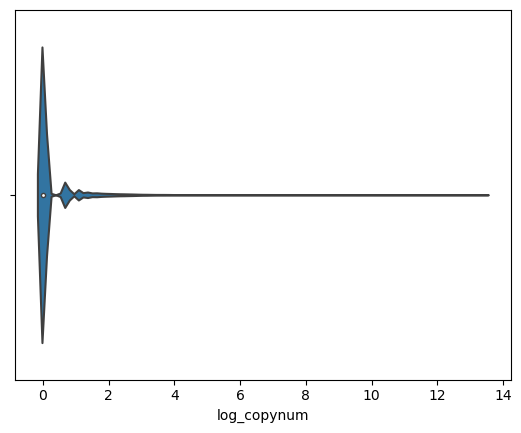

In [107]:
sns.violinplot(data=r12_c6_pd, x="log_copynum")
plt.show()

In [108]:
r12_c6_pd["log_copynum"].sum()

18114.26577846481

In [46]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

cluster_method = "db"
if cluster_method == "db":
    alg = DBSCAN(eps=1.8, metric='euclidean', min_samples=5000).fit(input_processed)
    core_samples_mask = np.zeros_like(alg.labels_, dtype=bool)
    core_samples_mask[alg.core_sample_indices_] = True

elif cluster_method == "op":
    alg = OPTICS(min_samples=2000, metric="euclidean").fit(input_processed)
    # core_distance_mask = np.zeros_like(alg.labels_, dtype=bool)
    # core_samples_mask[alg.core_sample_indices_] = True


labels = alg.labels_

In [48]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
cluster_id = set(labels)
for clust in cluster_id:
    print('Clust', clust, 'Length', list(labels).count(clust))

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Clust 0 Length 64206
Clust 1 Length 29728
Clust 2 Length 217801
Clust 3 Length 72241
Clust 4 Length 66688
Clust 5 Length 25061
Clust 6 Length 4459
Clust 7 Length 11366
Clust 8 Length 8262
Clust 9 Length 8348
Clust 10 Length 9604
Clust 11 Length 2128
Clust 12 Length 2212
Clust 13 Length 1143
Clust -1 Length 127694
Estimated number of clusters: 14
Estimated number of noise points: 127694


In [ ]:
# Now we should try to visualize each clusters sequence logo

r12_db_data = r12_data
r12_db_data["cluster"] = list(labels)

# Generate Sequence Logo for Each Cluster
db_paths_u, db_paths_w = [], []
for clust in cluster_id:
    db_paths_u.append(am.seq_logo(r12_db_data[r12_db_data["cluster"] == clust], f"db_c{clust}_seqlogo", weight=False, outdir="./generated/"))
    db_paths_w.append(am.seq_logo(r12_db_data[r12_db_data["cluster"] == clust], f"db_c{clust}_seqlogo", weight=True, outdir="./generated/"))


# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(rounds), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(rounds):
    img1 = mpimg.imread(f"{db_paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{db_paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()



In [27]:
# Elbow Point is at 4 so we will run it for 4 clusters
kmeans_pca = KMeans(n_clusters=7, init="k-means++", random_state=38)
kmeans_pca.fit(principal_components_4)
# Add principal components to dataframe
df_pca_kmeans = pd.concat([r12_data.reset_index(drop=True), pd.DataFrame(principal_components_4)], axis=1)
df_pca_kmeans.columns.values[-4:] = ["Component 1", "Component 2", "Component 3", "Component 4"]
# Add labels from kmeans
df_pca_kmeans["K-mean PCA Label"] = kmeans_pca.labels_
# Replace integer with label in new column
df_pca_kmeans["Segment"] = df_pca_kmeans["K-mean PCA Label"].map({0:'first', 1:'second', 2:"third", 3:'fourth', 4:'fifth', 5:"sixth", 6:"seventh", 7:"eighth"})

/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


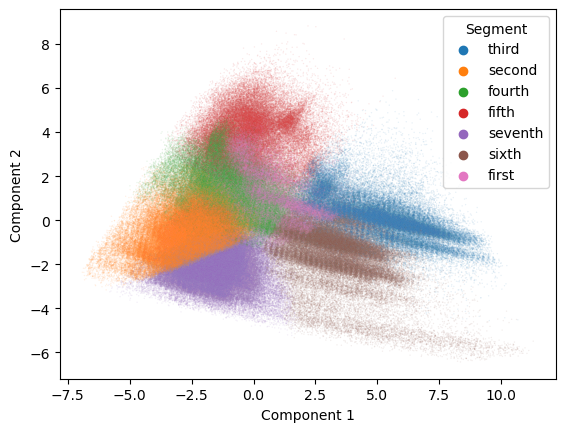

In [28]:
sns.scatterplot(data=df_pca_kmeans, x="Component 1", y="Component 2", hue="Segment", alpha=0.1, s=1)
plt.show()

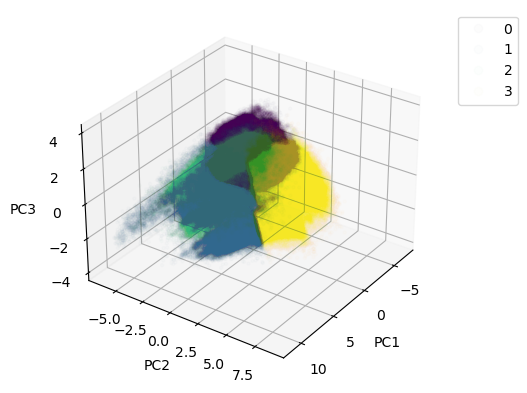

In [39]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".")
ax.view_init(30, 35)  # Set viewing angle
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

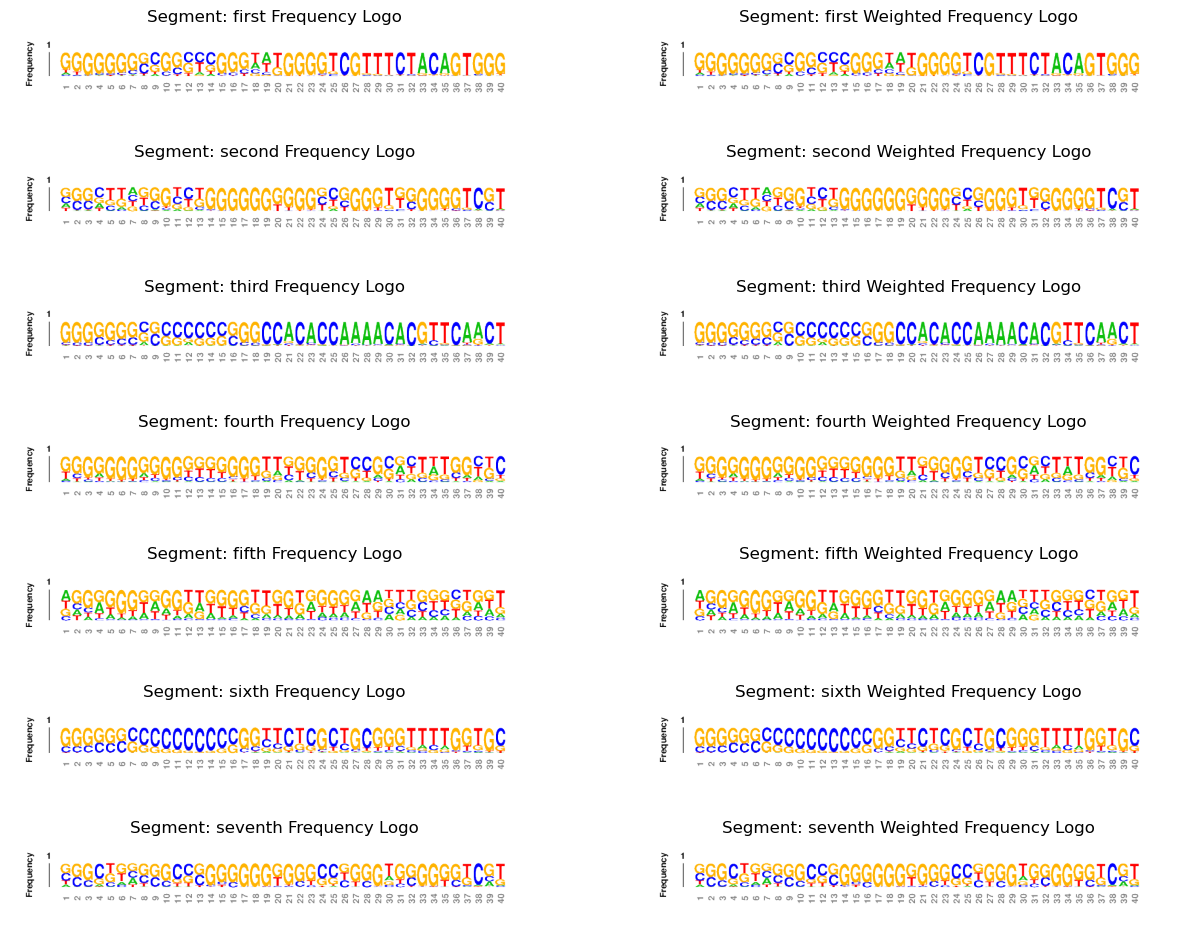

In [30]:
segments = ["first", "second", "third", "fourth", "fifth", "sixth", "seventh"]

# Generate Sequence Logo for Each Cluster
pca_paths_u, pca_paths_w = [], []
for seg in segments:
    pca_paths_u.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"db_c{seg}_seqlogo", weight=False, outdir="./generated/"))
    pca_paths_w.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"db_c{seg}_seqlogo", weight=True, outdir="./generated/"))


# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(segments), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(segments):
    img1 = mpimg.imread(f"{pca_paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{pca_paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"Segment: {r} Frequency Logo")
    axs[rid][1].set_title(f"Segment: {r} Weighted Frequency Logo")

plt.show()

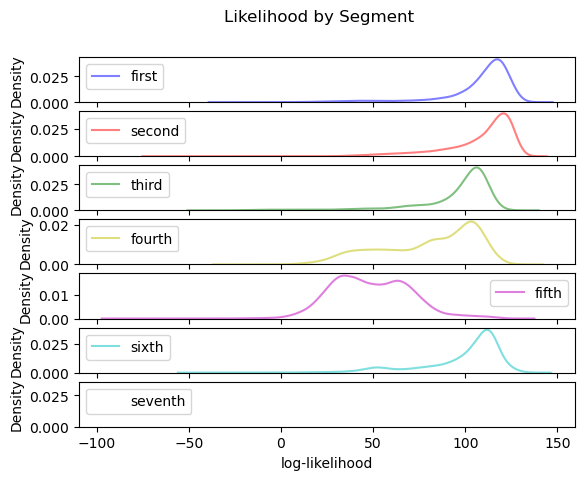

In [39]:
segments = ["first", "second", "third", "fourth", "fifth", "sixth", "seventh"]
# Plot Likelihood Curves of individual segments
df_pca_kmeans["likelihood"] = r12_likelihoods["likelihoods"]["r12"]
likelihood_dict = {}
for seg in segments:
    segment_subset = df_pca_kmeans[df_pca_kmeans["Segment"] == seg]
    likelihoods = segment_subset.likelihood.tolist()
    likelihood_dict[seg] = likelihoods


am.plot_likelihoods(likelihood_dict, segments, segments, title="Likelihood by Segment", xlim=None)

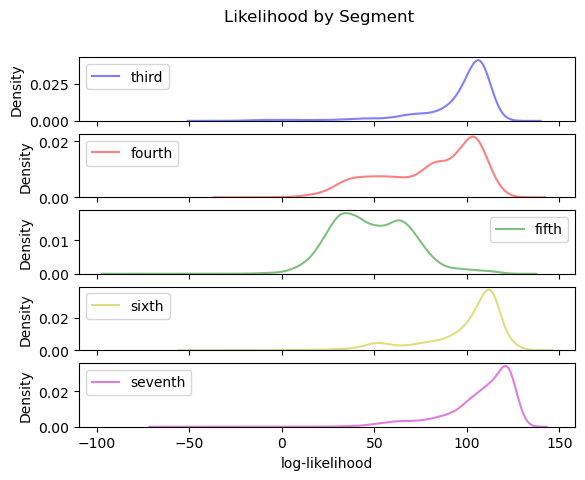

In [40]:
am.plot_likelihoods(likelihood_dict, segments[-5:], segments[-5:], title="Likelihood by Segment", xlim=None)

In [ ]:
am.plot_likelihoods(r12_likelihoods["likelihoods"], segments, segments, title=None, xaxislabel="log-likelihood", xlim=None, cdf=False)